# Denoising Diffusion Probabilistic Models

Original paper: https://arxiv.org/pdf/2006.11239.pdf

Original tutorial: https://youtu.be/a4Yfz2FxXiY

Original collab: https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing

Main idea: Implement a simple diffusion model for generating car images

## 1. Getting the dataset


The [original dataset link](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is down, so the download option wasn't working in torchvision. `data = torchvision.datasets.StanfordCars(root=".", download=True)` returns an HTTP 404 error.


We can get the dataset from Kaggle instead: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset?resource=download
BUT we need to follow the instructions from this quick fix: https://github.com/pytorch/vision/issues/7545#issuecomment-1631441616

**NOTES:** 
- Had to download files manually from the sources in that comment first! Make sure the directory structure matches what PyTorch expects.
- OG Pytorch code: https://github.com/pytorch/vision/blob/main/torchvision/datasets/stanford_cars.py

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os

In [113]:
train_data = torchvision.datasets.StanfordCars(root="../data/")
test_data = torchvision.datasets.StanfordCars(root="../data/", split="test")

In [114]:
def show_image_samples(dataset, num_samples=20, cols=4):
    """Plots num_samples image samples from the dataset"""
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        

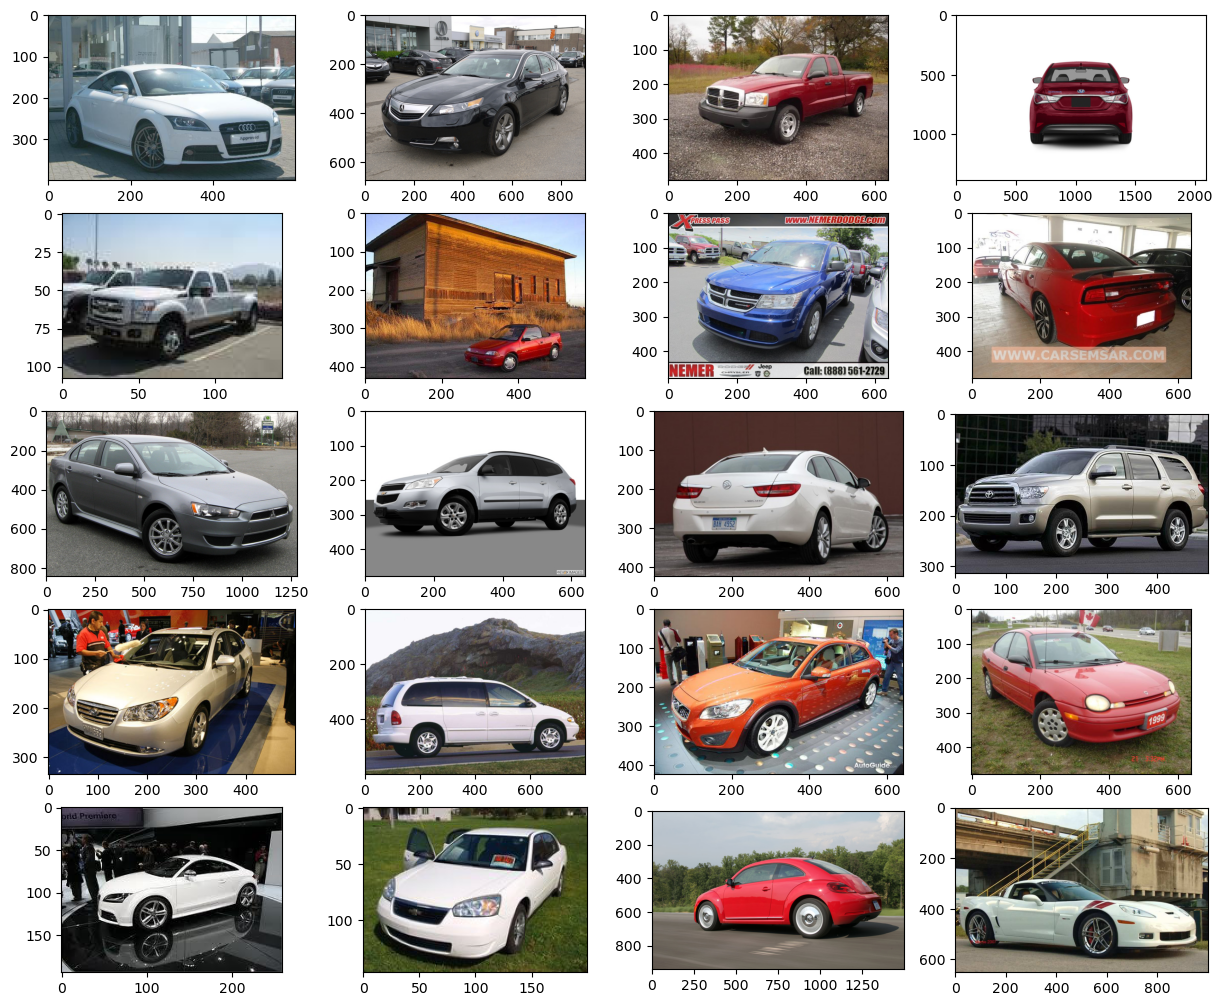

In [115]:
show_image_samples(train_data)

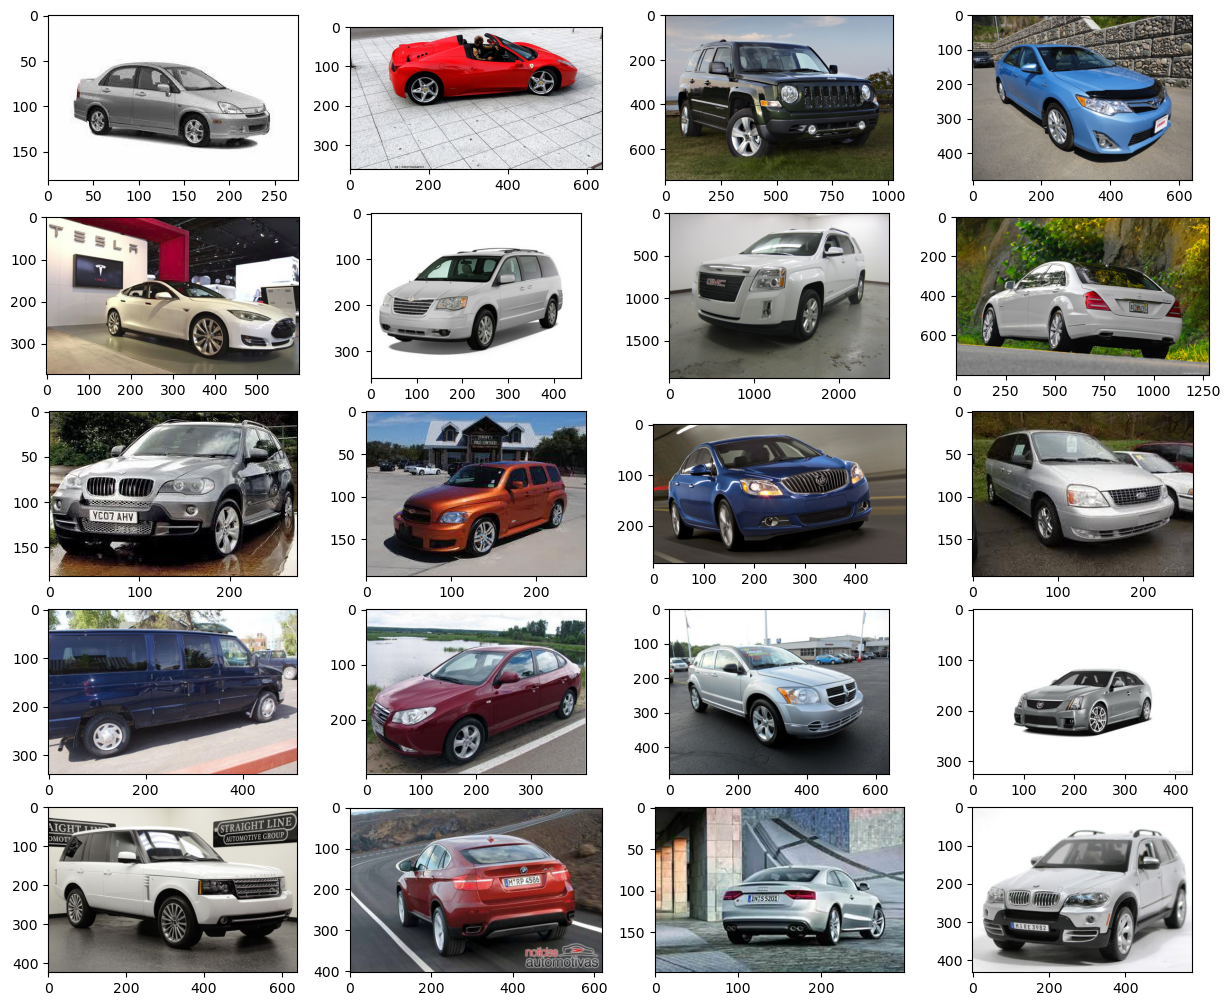

In [116]:
show_image_samples(test_data)